In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import add, Input, Dense, Conv2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Concatenate, Reshape, Activation, BatchNormalization, GlobalAveragePooling2D, ZeroPadding2D
from tensorflow.nn import local_response_normalization
from tensorflow.python.keras.layers.merge import concatenate
from tensorflow.keras.activations import relu
import sys
import matplotlib.pyplot as plt
import math
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2, l1, l1_l2
from itertools import permutations, combinations
import cv2

In [2]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
# config.gpu_options.per_process_gpu_memory_fraction = 0.60
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 3080, pci bus id: 0000:41:00.0, compute capability: 8.6



In [3]:
#### Using CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255


y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10) 

global_batch_size = 32
image_resize = 32

########## Train
##################################################################################
##################################################################################
##################################################################################
##################################################################################
##################################################################################
#### removing data augmentation only here for profiling
train_datagen = ImageDataGenerator(rescale=1./255)

train_it = train_datagen.flow_from_directory(
        'cifar10/train',
        class_mode='categorical',
        target_size=(image_resize, image_resize),
        batch_size=global_batch_size,
        shuffle=False, seed=545)


############ Test
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

validation_it = test_datagen.flow_from_directory(
        'cifar10/test',
        class_mode='categorical',
        target_size=(image_resize, image_resize),
        batch_size=global_batch_size,
        subset = "training",seed = 545)

test_it = test_datagen.flow_from_directory(
        'cifar10/test',
        class_mode='categorical',
        target_size=(image_resize, image_resize),
        batch_size=global_batch_size,
        subset = "validation",
        seed = 545)


for data_batch, labels_batch in train_it:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


Found 50000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
data batch shape: (32, 32, 32, 3)
labels batch shape: (32, 10)


In [4]:
class CustomLoss(keras.losses.Loss):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, y_true, y_pred):
        ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
        return ce * self.factor
    
class Residual_block(tf.keras.Model):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        
        self.conv1 = Conv2D(num_channels, kernel_size=3, padding='same', strides=strides, kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))
        self.conv2 = Conv2D(num_channels, kernel_size=3, padding='same', kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))
        self.conv3 = None
        
        if use_1x1conv:
            self.conv3 = Conv2D(num_channels, kernel_size=1, strides=strides, kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))
            
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()
        
    def call(self, X, training):
        
        if (training != False and training != True):
            training = False
        
        Y = self.conv1(X)
        Y = self.bn1 (Y, training = training)
        Y = relu(Y)
        Y = self.conv2(Y)
        Y = self.bn2 (Y, training = training)
        
        if self.conv3 is not None:
            X = self.conv3(X)
            
        Y += X
        Y = relu(Y)
        return Y


class CIFAR_ResNet(tf.keras.Model):
    def __init__(self, model_n, branch_number):
        super(CIFAR_ResNet, self).__init__()
        
        self.model_n = model_n
        self.branch_number = branch_number
        self.residual_layers = []
        
        ######## Begining Layers
        self.conv1 = Conv2D(16, kernel_size=3, padding='same',kernel_initializer='he_uniform', input_shape=(image_resize, image_resize, 3), kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001))
        self.bn1 = BatchNormalization()
        
        
        ######## ResNet layers
        ### first block, 16 channels
        for i in range(self.model_n):
            self.residual_layers.append(Residual_block(16))
            
        ### second block, 32 channels
        for i in range(self.model_n):
            if i == 0:
                self.residual_layers.append(Residual_block(32, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual_block(32))
                
        ### third block, 64 channels
        self.residual_layers_block3 = []
        for i in range(self.model_n):
            if i == 0:
                self.residual_layers.append(Residual_block(64, use_1x1conv=True, strides=2))
            else:
                self.residual_layers.append(Residual_block(64))

        
        ######## OUTPUT Layers
        self.pool_out = GlobalAveragePooling2D()
        self.flat_out = Flatten()

        self.dense_layers = []
        for i in range(self.branch_number):
            self.dense_layers.append(Dense(10, kernel_initializer='he_uniform', kernel_regularizer=l2(0.00001), bias_regularizer=l2(0.00001), activation='softmax'))
        

    def call(self, inputs, training):
        inference_flag = -1000
        layer_ind_counter = 0
        comp_latency_list_backbone = [0 for i in range(self.branch_number)]
        comp_latency_list_exitbranch = [0 for i in range(self.branch_number)]
        out_vector_list = [[] for i in range(self.branch_number)]
        
        if (training != False and training != True):
            inference_flag = 1000
            training = False
            
            
        ##### Begining layers
        start_time = tf.timestamp()
        x = self.conv1(inputs)
        x = self.bn1 (x, training = training)
        x = relu (x)
        comp_latency_list_backbone[layer_ind_counter] = tf.timestamp() - start_time
        
        
        # exit branch
        start_time = tf.timestamp()
        temp = self.pool_out(x)
        temp = self.flat_out(temp)
        out_vector_list[layer_ind_counter] = self.dense_layers[layer_ind_counter](temp)
        comp_latency_list_exitbranch[layer_ind_counter] = tf.timestamp() - start_time
        
        
        
        ##### ResNet Layers
        for layer in self.residual_layers:
            layer_ind_counter += 1
            start_time = tf.timestamp()
            x = layer (x)
            comp_latency_list_backbone[layer_ind_counter] = tf.timestamp() - start_time
            
            # add exit branch after each resnet block
            start_time = tf.timestamp()
            temp = self.pool_out(x)
            temp = self.flat_out(temp)
            out_vector_list[layer_ind_counter] = self.dense_layers[layer_ind_counter](temp)
            comp_latency_list_exitbranch[layer_ind_counter] = tf.timestamp() - start_time
            


        if (inference_flag == 1000):
            return(out_vector_list, comp_latency_list_backbone, comp_latency_list_exitbranch)
        
        
        return out_vector_list
    
    
    

##### load weight
opt = tf.keras.optimizers.SGD(momentum=0.9)

##### for ResNet20
branch_number= 10
model_n = 3

ls = [CustomLoss(1) for i in range(branch_number)]

model_CIFAR_ResNet = CIFAR_ResNet(model_n,branch_number)
model_CIFAR_ResNet.compile(optimizer=opt, loss=ls, metrics=['accuracy'])
model_CIFAR_ResNet.load_weights('profiling_models/ResNet20_10out_bs32_epoch800_lr0.01_new')
model_CIFAR_ResNet.evaluate(test_it);

157/157 [==============================] - 6s 23ms/step - loss: 8.5724 - output_1_loss: 1.7556 - output_2_loss: 1.2076 - output_3_loss: 1.0540 - output_4_loss: 1.0171 - output_5_loss: 0.7794 - output_6_loss: 0.5720 - output_7_loss: 0.5007 - output_8_loss: 0.4383 - output_9_loss: 0.3808 - output_10_loss: 0.3652 - output_1_accuracy: 0.3992 - output_2_accuracy: 0.5918 - output_3_accuracy: 0.6510 - output_4_accuracy: 0.6742 - output_5_accuracy: 0.7652 - output_6_accuracy: 0.8232 - output_7_accuracy: 0.8432 - output_8_accuracy: 0.8660 - output_9_accuracy: 0.8790 - output_10_accuracy: 0.8848


In [7]:
##### passing TRAIN samples through model
##### this is to save computation time and exit rates for all the possible branches

per_sample_label_list = []
per_sample_out_vector_list = []
per_sample_comp_latency_backbone_list = []
per_sample_comp_latency_exitbranch_list = []


#### saving intermediate data once
for i in range (len(train_it)):
    temp_batch = train_it[i]

    for j in range (len(temp_batch[0])):
        pic = temp_batch[0][j]
        label = temp_batch[1][j]
        per_sample_label_list.append(np.array(label).reshape(1,10))

        res = model_CIFAR_ResNet(np.array(pic.reshape(1,image_resize,image_resize,3)), training = 1000)
   
        per_sample_out_vector_list.append(res[0])
        per_sample_comp_latency_backbone_list.append(res[1])
        per_sample_comp_latency_exitbranch_list.append(res[2])

print ("computation latencies backbone(train data)   ", np.mean(per_sample_comp_latency_backbone_list, axis=0)*1000)
print ("computation latencies exitbranch(train data)   ", np.mean(per_sample_comp_latency_exitbranch_list, axis=0)*1000)




##### passing TRAIN samples through model
##### this is to save computation time and exit rates for all the possible branches

entropy_threshold_list = np.linspace(0.000000001, 0.999999, num=20)

### all possible branches, and chosen number
branch_number = 10
chosen_number = 10
I = list(range(1, branch_number+1))

#### number of train samples for simulation
sample_number = 50000


# permuted_exitrate_list = []

#### per placement, in this case it is only 1, all the possible branches
for item in combinations(I, chosen_number):
    placement = list(np.array(item))
    print ("&&&&& selected exit ", placement , "  &&&&&&")
        
    ent_exitrate_list = []

    ##### per threshold 
    for thresh in entropy_threshold_list:
        print ("------------------ ", thresh, "------------------------")

        threshold_exit = []
        threshold_exitrate = [[] for i in range(branch_number)]

        ##### per sample
        for sample in range (sample_number):

            #### determining the exit branch based on entropy of the output and thresh
            for exit in range(branch_number):
                out = per_sample_out_vector_list[sample][exit]
                entropy = -1 * tf.math.reduce_sum((tf.math.log(out) * out)/ np.log(out.shape[1]))

                if (entropy < thresh or exit+1==branch_number):
                    threshold_exit.append(exit+1)
                    break


        # handling exit percentage part
        unique, counts = np.unique(threshold_exit, return_counts=True)
        exitper_list_dict = dict(zip(unique, counts))
        print ("exit rate per thresh ", exitper_list_dict)

        for i in range(branch_number):
            if (exitper_list_dict.get(placement[i]) is None):
                threshold_exitrate[i].append (0)
            else:
                threshold_exitrate[i].append(exitper_list_dict.get(placement[i]))


        ent_exitrate_list.append(np.mean(threshold_exitrate, axis=1)/sample_number)

    print("------------------------------------------------------------------")
    print("exit rate average ", np.mean(ent_exitrate_list, axis=0))
    break


    
    
##### passing TEST samples through model once and save the intermediate data
#### this is for doing the simulation

per_sample_label_list = []
per_sample_out_vector_list = []
per_sample_comp_latency_backbone_list = []
per_sample_comp_latency_exitbranch_list = []

for i in range (len(test_it)):
    temp_batch = test_it[i]

    for j in range (len(temp_batch[0])):
        pic = temp_batch[0][j]
        label = temp_batch[1][j]
        per_sample_label_list.append(np.array(label).reshape(1,10))

        res = model_CIFAR_ResNet(np.array(pic.reshape(1,image_resize,image_resize,3)), training = 1000)
   
        per_sample_out_vector_list.append(res[0])
        per_sample_comp_latency_backbone_list.append(res[1])
        per_sample_comp_latency_exitbranch_list.append(res[2])
        
print ("computation latencies backbone(test data)   ", np.mean(per_sample_comp_latency_backbone_list, axis=0)*1000)
print ("computation latencies exitbranch(test data)   ", np.mean(per_sample_comp_latency_exitbranch_list, axis=0)*1000)


computation latencies backbone(train data)    [0.98884088 1.59857132 1.42036943 1.3799052  1.62198948 1.33477669
 1.33001278 1.56900894 1.28387018 1.28202384]
computation latencies exitbranch(train data)    [0.54213895 0.56646625 0.56766025 0.54766169 0.54161145 0.53786012
 0.53404621 0.53869868 0.53563244 0.53338953]
&&&&& selected exit  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   &&&&&&
------------------  1e-09 ------------------------
exit rate per thresh  {6: 14, 7: 23, 8: 40, 9: 123, 10: 49800}
------------------  0.052631527263157896 ------------------------
exit rate per thresh  {1: 802, 2: 3435, 3: 4150, 4: 2270, 5: 7682, 6: 7863, 7: 3649, 8: 4254, 9: 3258, 10: 12637}
------------------  0.10526305352631579 ------------------------
exit rate per thresh  {1: 1479, 2: 5763, 3: 5648, 4: 2715, 5: 8320, 6: 7636, 7: 3325, 8: 3619, 9: 2731, 10: 8764}
------------------  0.1578945797894737 ------------------------
exit rate per thresh  {1: 2167, 2: 8004, 3: 6311, 4: 3064, 5: 8572, 6: 7129, 7: 2

In [9]:
entropy_threshold_list = np.linspace(0.000000001, 0.999999, num=20)

###########################################################
### ResNet20 model related information

### all possible branches
branch_number = 10
I = list(range(1, branch_number+1))

input_size = 32*32*3*32
out_size = {1:32*32*16*32, 2:32*32*16*32, 3:32*32*16*32, 4:32*32*16*32, 5:16*16*32*32, 6:16*16*32*32, 7:16*16*32*32, 8:8*8*64*32, 9:8*8*64*32, 10:8*8*64*32}

###########################################################
### tier and device related information

### all possible tiers
tier_number = 5
J = list(range(1, tier_number+1))

prop = [10, 20, 20, 10]
bw = [54000, 54000, 1000000, 1000000]
comp_ratio = {1:10, 2:5, 3:2, 4:1, 5:0.5}

#### other parametes  
option_entire_DNN = True
option_last_tier = False

#### result
class_number = 10
result_size = math.ceil(math.log2(class_number))

#### number of test samples for simulation, default is 5000
sample_number = len(per_sample_label_list)


def func_list_to_dict(li):
    di = {}
    for i in range(len(li)):
        if(li[i]!=0):
            di[i+1]=li[i]
    return di


In [10]:
############## simulation with 1 chosen tiers

#### chosen number of tiers
chosen_number = 1

t1_placement_with0_list = []
t1_simulated_accuracy_list = []
t1_simulated_prop_latency_list = []
t1_simulated_trans_latency_list = []
t1_simulated_comp_latency_list = []
t1_simulated_total_latency_list = []
t1_simulated_exitrate_list = []
t1_simulated_placement_list = []

for item in combinations(I, chosen_number):
    
    #### constraint about using the entire DNN model
    if (len(I) not in item and option_entire_DNN == True):
        continue
    
    print("-------------------------------  ", item)
    item = list(item) + [0 for i in range(tier_number - chosen_number)]
    
    for placement in permutations(item, tier_number):
        if (sorted([i for i in placement if i!=0]) == [i for i in placement if i!=0] and list(placement) not in t1_placement_with0_list):
            
            t1_placement_with0_list.append(list(placement))
            placement_dict = func_list_to_dict(list(placement))
            print("*********** ", placement_dict, " *************")
            
            
            ent_prop_latency_list = []
            ent_trans_latency_list = []
            ent_comp_latency_list = []
            ent_total_latency_list = []
            ent_accuracy_list = []
            ent_exitrate_list = []
            
            for thresh in entropy_threshold_list:
#                 print ("------------------threshold >>>>> ", thresh)
                
                
                threshold_exit = []
                threshold_exitrate = [[] for i in range(branch_number)]
                threshold_prop_time = []
                threshold_trans_time = []
                threshold_comp_time = []
                threshold_pred_list = []
                
                ##### per sample
                for sample in range (sample_number):
                                    
                    chosen_branches = list(placement_dict.values())
                    chosen_tiers = list(placement_dict.keys())
                    zip_tier_branch = np.transpose((chosen_tiers, chosen_branches))
                    
                    
                    ### begining values for latencies. p and t depends on first chosen tier. c is always 0.
                    p = sum(prop[0:chosen_tiers[0]-1])
                    t = input_size*sum(1/b for b in bw[0:chosen_tiers[0]-1])
                    c = 0

                    #### determining the exit branch based on entropy of the output and thresh
                    for index, [tier, branch] in enumerate(zip_tier_branch):
                        out = per_sample_out_vector_list[sample][branch-1]
                        entropy = -1 * tf.math.reduce_sum((tf.math.log(out) * out)/ np.log(out.shape[1]))
                        
                        prev_branch = 0 if index==0 else zip_tier_branch[index-1][1]
                        c += sum(per_sample_comp_latency_backbone_list[sample][a] for a in list(range(prev_branch, branch)))*1000*comp_ratio[tier] 
                        
                        
                        #### if exit (wether threshold in ok or its last tier)
                        if (entropy < thresh or tier == chosen_tiers[-1]):
                            c += per_sample_comp_latency_exitbranch_list[sample][branch-1]*1000*comp_ratio[tier] 
                            
                            #### after exit, we send the result back to tier one, adds to propagation and tranmission latency
                            p += sum(prop[0: tier-1])
                            t += result_size*sum(1/b for b in bw[0: tier-1])
                            
                            threshold_prop_time.append(p)
                            threshold_trans_time.append(t)
                            threshold_comp_time.append(c)

                            threshold_exit.append(branch)
                            threshold_pred_list.append(out)
                            break
                            
                        ### if not exit, propagation latency and transmission latency
                        else:
                            
                            next_tier = zip_tier_branch[index+1][0]
                            p += sum(prop[tier-1: next_tier-1])
                            t += out_size[branch]*sum(1/b for b in bw[tier-1: next_tier-1])
            
                ### after one sample is done, for each threshold
                # handling exit percentage part
                unique, counts = np.unique(threshold_exit, return_counts=True)
                exitper_list_dict = dict(zip(unique, counts))

                for i in range(branch_number):
                    if (exitper_list_dict.get(i+1) is None):
                        threshold_exitrate[i].append (0)
                    else:
                        threshold_exitrate[i].append(exitper_list_dict.get(i+1))


                ent_prop_latency_list.append(np.mean(threshold_prop_time))
                ent_trans_latency_list.append(np.mean(threshold_trans_time))
                ent_comp_latency_list.append(np.mean(threshold_comp_time))
                ent_total_latency_list.append(np.mean(threshold_prop_time)+np.mean(threshold_trans_time)+np.mean(threshold_comp_time))
                ent_accuracy_list.append(np.sum(tf.argmax(np.array(per_sample_label_list[0:sample_number]).reshape(sample_number,10), 1) == tf.argmax(np.array(threshold_pred_list).reshape(sample_number,10), 1))/sample_number)
                ent_exitrate_list.append(np.mean(threshold_exitrate, axis=1)/sample_number)
                
                
#                 print("prop  ",  np.mean(threshold_prop_time))
#                 print("trans  ", np.mean(threshold_trans_time))
#                 print("comp  ", np.mean(threshold_comp_time))
#                 print("total  ", np.mean(threshold_prop_time)+np.mean(threshold_trans_time)+np.mean(threshold_comp_time))
#                 print("acc ", np.sum(tf.argmax(np.array(per_sample_label_list[0:sample_number]).reshape(sample_number,10), 1) == tf.argmax(np.array(threshold_pred_list).reshape(sample_number,10), 1))/sample_number)
#                 print("exit rate: ", np.mean(threshold_exitrate, axis=1)/sample_number)
                
            
            
            ### after all thresholds are done, for each placement
            t1_simulated_prop_latency_list.append(np.mean(ent_prop_latency_list))
            t1_simulated_trans_latency_list.append(np.mean(ent_trans_latency_list))
            t1_simulated_comp_latency_list.append(np.mean(ent_comp_latency_list))
            t1_simulated_total_latency_list.append(np.mean(ent_total_latency_list))
            t1_simulated_accuracy_list.append(np.mean(ent_accuracy_list))
            t1_simulated_exitrate_list.append(np.mean(ent_exitrate_list, axis=0))
            t1_simulated_placement_list.append(placement_dict)

            print (" ********************  placement average results ")
            print("prop average ", np.mean(ent_prop_latency_list))
            print("trans average ", np.mean(ent_trans_latency_list))
            print("computation average ", np.mean(ent_comp_latency_list))
            print("total average ", np.mean(ent_total_latency_list))
            print("accuracy average ", np.mean(ent_accuracy_list))
            print("exit rate average ", np.mean(ent_exitrate_list, axis=0))
            
            
print ("---- simulation result------")
print("min latency: value->   ", min(t1_simulated_total_latency_list), "  placement->  ", t1_simulated_placement_list[t1_simulated_total_latency_list.index(min(t1_simulated_total_latency_list))])
print("max accuracy: value->   ", max(t1_simulated_accuracy_list), "   placement->   ", t1_simulated_placement_list[t1_simulated_accuracy_list.index(max(t1_simulated_accuracy_list))])


-------------------------------   (10,)
***********  {1: 10}  *************
 ********************  placement average results 
prop average  0.0
trans average  0.0
computation average  143.44967412948608
total average  143.44967412948608
accuracy average  0.8847999999999999
exit rate average  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
***********  {2: 10}  *************
 ********************  placement average results 
prop average  20.0
trans average  1.8205185185185182
computation average  71.72483706474304
total average  93.54535558326158
accuracy average  0.8847999999999999
exit rate average  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
***********  {3: 10}  *************
 ********************  placement average results 
prop average  60.0
trans average  3.6410370370370364
computation average  28.68993482589722
total average  92.33097186293428
accuracy average  0.8847999999999999
exit rate average  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
***********  {4: 10}  *************
 ********************  placement average 

In [16]:
############## simulation with 1 chosen tiers

#### chosen number of tiers
chosen_number = 2

t2_placement_with0_list = []
t2_simulated_accuracy_list = []
t2_simulated_prop_latency_list = []
t2_simulated_trans_latency_list = []
t2_simulated_comp_latency_list = []
t2_simulated_total_latency_list = []
t2_simulated_exitrate_list = []
t2_simulated_placement_list = []

for item in combinations(I, chosen_number):
    
    #### constraint about using the entire DNN model
    if (len(I) not in item and option_entire_DNN == True):
        continue
    
    print("-------------------------------  ", item)
    item = list(item) + [0 for i in range(tier_number - chosen_number)]
    
    for placement in permutations(item, tier_number):
        if (sorted([i for i in placement if i!=0]) == [i for i in placement if i!=0] and list(placement) not in t2_placement_with0_list):
            
            t2_placement_with0_list.append(list(placement))
            placement_dict = func_list_to_dict(list(placement))
            print("*********** ", placement_dict, " *************")
            
            
            ent_prop_latency_list = []
            ent_trans_latency_list = []
            ent_comp_latency_list = []
            ent_total_latency_list = []
            ent_accuracy_list = []
            ent_exitrate_list = []
            
            for thresh in entropy_threshold_list:
#                 print ("------------------threshold >>>>> ", thresh)
                
                
                threshold_exit = []
                threshold_exitrate = [[] for i in range(branch_number)]
                threshold_prop_time = []
                threshold_trans_time = []
                threshold_comp_time = []
                threshold_pred_list = []
                
                ##### per sample
                for sample in range (sample_number):
                                    
                    chosen_branches = list(placement_dict.values())
                    chosen_tiers = list(placement_dict.keys())
                    zip_tier_branch = np.transpose((chosen_tiers, chosen_branches))
                    
                    
                    ### begining values for latencies. p and t depends on first chosen tier. c is always 0.
                    p = sum(prop[0:chosen_tiers[0]-1])
                    t = input_size*sum(1/b for b in bw[0:chosen_tiers[0]-1])
                    c = 0

                    #### determining the exit branch based on entropy of the output and thresh
                    for index, [tier, branch] in enumerate(zip_tier_branch):
                        out = per_sample_out_vector_list[sample][branch-1]
                        entropy = -1 * tf.math.reduce_sum((tf.math.log(out) * out)/ np.log(out.shape[1]))
                        
                        prev_branch = 0 if index==0 else zip_tier_branch[index-1][1]
                        c += sum(per_sample_comp_latency_backbone_list[sample][a] for a in list(range(prev_branch, branch)))*1000*comp_ratio[tier] 
                        
                        
                        #### if exit (wether threshold in ok or its last tier)
                        if (entropy < thresh or tier == chosen_tiers[-1]):
                            c += per_sample_comp_latency_exitbranch_list[sample][branch-1]*1000*comp_ratio[tier] 
                            
                            #### after exit, we send the result back to tier one, adds to propagation and tranmission latency
                            p += sum(prop[0: tier-1])
                            t += result_size*sum(1/b for b in bw[0: tier-1])
                            
                            threshold_prop_time.append(p)
                            threshold_trans_time.append(t)
                            threshold_comp_time.append(c)

                            threshold_exit.append(branch)
                            threshold_pred_list.append(out)
                            break
                            
                        ### if not exit, propagation latency and transmission latency
                        else:
                            
                            next_tier = zip_tier_branch[index+1][0]
                            p += sum(prop[tier-1: next_tier-1])
                            t += out_size[branch]*sum(1/b for b in bw[tier-1: next_tier-1])
            
                ### after one sample is done, for each threshold
                # handling exit percentage part
                unique, counts = np.unique(threshold_exit, return_counts=True)
                exitper_list_dict = dict(zip(unique, counts))

                for i in range(branch_number):
                    if (exitper_list_dict.get(i+1) is None):
                        threshold_exitrate[i].append (0)
                    else:
                        threshold_exitrate[i].append(exitper_list_dict.get(i+1))


                ent_prop_latency_list.append(np.mean(threshold_prop_time))
                ent_trans_latency_list.append(np.mean(threshold_trans_time))
                ent_comp_latency_list.append(np.mean(threshold_comp_time))
                ent_total_latency_list.append(np.mean(threshold_prop_time)+np.mean(threshold_trans_time)+np.mean(threshold_comp_time))
                ent_accuracy_list.append(np.sum(tf.argmax(np.array(per_sample_label_list[0:sample_number]).reshape(sample_number,10), 1) == tf.argmax(np.array(threshold_pred_list).reshape(sample_number,10), 1))/sample_number)
                ent_exitrate_list.append(np.mean(threshold_exitrate, axis=1)/sample_number)
                
                
#                 print("prop  ",  np.mean(threshold_prop_time))
#                 print("trans  ", np.mean(threshold_trans_time))
#                 print("comp  ", np.mean(threshold_comp_time))
#                 print("total  ", np.mean(threshold_prop_time)+np.mean(threshold_trans_time)+np.mean(threshold_comp_time))
#                 print("acc ", np.sum(tf.argmax(np.array(per_sample_label_list[0:sample_number]).reshape(sample_number,10), 1) == tf.argmax(np.array(threshold_pred_list).reshape(sample_number,10), 1))/sample_number)
#                 print("exit rate: ", np.mean(threshold_exitrate, axis=1)/sample_number)
                
            
            
            ### after all thresholds are done, for each placement
            t2_simulated_prop_latency_list.append(np.mean(ent_prop_latency_list))
            t2_simulated_trans_latency_list.append(np.mean(ent_trans_latency_list))
            t2_simulated_comp_latency_list.append(np.mean(ent_comp_latency_list))
            t2_simulated_total_latency_list.append(np.mean(ent_total_latency_list))
            t2_simulated_accuracy_list.append(np.mean(ent_accuracy_list))
            t2_simulated_exitrate_list.append(np.mean(ent_exitrate_list, axis=0))
            t2_simulated_placement_list.append(placement_dict)

            print (" ********************  placement average results ")
            print("prop average ", np.mean(ent_prop_latency_list))
            print("trans average ", np.mean(ent_trans_latency_list))
            print("computation average ", np.mean(ent_comp_latency_list))
            print("total average ", np.mean(ent_total_latency_list))
            print("accuracy average ", np.mean(ent_accuracy_list))
            print("exit rate average ", np.mean(ent_exitrate_list, axis=0))
            
            
print ("---- simulation result------")
print("min latency: value->   ", min(t2_simulated_total_latency_list), "  placement->  ", t2_simulated_placement_list[t2_simulated_total_latency_list.index(min(t2_simulated_total_latency_list))])
print("max accuracy: value->   ", max(t2_simulated_accuracy_list), "   placement->   ", t2_simulated_placement_list[t2_simulated_accuracy_list.index(max(t2_simulated_accuracy_list))])


-------------------------------   (1, 10)
***********  {1: 1, 2: 10}  *************
 ********************  placement average results 
prop average  12.1794
trans average  5.9125573933333335
computation average  52.52289116382599
total average  70.61484855715932
accuracy average  0.71784
exit rate average  [0.39103 0.      0.      0.      0.      0.      0.      0.      0.
 0.60897]
***********  {1: 1, 3: 10}  *************
 ********************  placement average results 
prop average  36.538199999999996
trans average  11.825114786666667
computation average  28.107072262763978
total average  76.47038704943066
accuracy average  0.71784
exit rate average  [0.39103 0.      0.      0.      0.      0.      0.      0.      0.
 0.60897]
***********  {1: 1, 4: 10}  *************
 ********************  placement average results 
prop average  60.897000000000006
trans average  12.144392885906669
computation average  19.968465962409972
total average  93.00985884831664
accuracy average  0.71784
ex

 ********************  placement average results 
prop average  39.9156
trans average  6.807873753697777
computation average  44.937604578733435
total average  91.66107833243122
accuracy average  0.7591300000000001
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.      0.      0.
 0.33263]
***********  {2: 3, 3: 10}  *************
 ********************  placement average results 
prop average  33.3052
trans average  5.0500601474074065
computation average  28.50026613235474
total average  66.85552627976216
accuracy average  0.7591300000000001
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.      0.      0.
 0.33263]
***********  {2: 3, 4: 10}  *************
 ********************  placement average results 
prop average  46.610400000000006
trans average  5.224455395367407
computation average  25.05371536493302
total average  76.88857076030044
accuracy average  0.7591300000000001
exit rate average  [0.      0.      0.66737 0.      0.      0.     

 ********************  placement average results 
prop average  42.71
trans average  3.0420641178962966
computation average  37.540138584375384
total average  83.29220270227168
accuracy average  0.8116200000000001
exit rate average  [0.     0.     0.     0.     0.7729 0.     0.     0.     0.     0.2271]
***********  {3: 5, 4: 10}  *************
 ********************  placement average results 
prop average  69.08399999999999
trans average  3.7005708478370374
computation average  16.342053425312038
total average  89.12662427314908
accuracy average  0.8116200000000001
exit rate average  [0.     0.     0.     0.     0.7729 0.     0.     0.     0.     0.2271]
***********  {3: 5, 5: 10}  *************
 ********************  placement average results 
prop average  73.626
trans average  3.7601046586370375
computation average  15.513304680585861
total average  92.8994093392229
accuracy average  0.8116200000000001
exit rate average  [0.     0.     0.     0.     0.7729 0.     0.     0.     0.  

 ********************  placement average results 
prop average  2.7889999999999997
trans average  0.3384916333333333
computation average  119.3900715470314
total average  122.51756318036473
accuracy average  0.8732
exit rate average  [0.      0.      0.      0.      0.      0.      0.      0.86055 0.
 0.13945]
***********  {1: 8, 3: 10}  *************
 ********************  placement average results 
prop average  8.367
trans average  0.6769832666666666
computation average  118.10132994651795
total average  127.14531321318461
accuracy average  0.8732
exit rate average  [0.      0.      0.      0.      0.      0.      0.      0.86055 0.
 0.13945]
***********  {1: 8, 4: 10}  *************
 ********************  placement average results 
prop average  13.945000000000002
trans average  0.6952618148666666
computation average  117.67174941301346
total average  132.3120112278801
accuracy average  0.8732
exit rate average  [0.      0.      0.      0.      0.      0.      0.      0.86055 0.
 0

In [18]:
############## simulation with 1 chosen tiers

#### chosen number of tiers
chosen_number = 3

t3_placement_with0_list = []
t3_simulated_accuracy_list = []
t3_simulated_prop_latency_list = []
t3_simulated_trans_latency_list = []
t3_simulated_comp_latency_list = []
t3_simulated_total_latency_list = []
t3_simulated_exitrate_list = []
t3_simulated_placement_list = []

for item in combinations(I, chosen_number):
    
    #### constraint about using the entire DNN model
    if (len(I) not in item and option_entire_DNN == True):
        continue
    
    print("-------------------------------  ", item)
    item = list(item) + [0 for i in range(tier_number - chosen_number)]
    
    for placement in permutations(item, tier_number):
        if (sorted([i for i in placement if i!=0]) == [i for i in placement if i!=0] and list(placement) not in t3_placement_with0_list):
            
            t3_placement_with0_list.append(list(placement))
            placement_dict = func_list_to_dict(list(placement))
            print("*********** ", placement_dict, " *************")
            
            
            ent_prop_latency_list = []
            ent_trans_latency_list = []
            ent_comp_latency_list = []
            ent_total_latency_list = []
            ent_accuracy_list = []
            ent_exitrate_list = []
            
            for thresh in entropy_threshold_list:
#                 print ("------------------threshold >>>>> ", thresh)
                
                
                threshold_exit = []
                threshold_exitrate = [[] for i in range(branch_number)]
                threshold_prop_time = []
                threshold_trans_time = []
                threshold_comp_time = []
                threshold_pred_list = []
                
                ##### per sample
                for sample in range (sample_number):
                                    
                    chosen_branches = list(placement_dict.values())
                    chosen_tiers = list(placement_dict.keys())
                    zip_tier_branch = np.transpose((chosen_tiers, chosen_branches))
                    
                    
                    ### begining values for latencies. p and t depends on first chosen tier. c is always 0.
                    p = sum(prop[0:chosen_tiers[0]-1])
                    t = input_size*sum(1/b for b in bw[0:chosen_tiers[0]-1])
                    c = 0

                    #### determining the exit branch based on entropy of the output and thresh
                    for index, [tier, branch] in enumerate(zip_tier_branch):
                        out = per_sample_out_vector_list[sample][branch-1]
                        entropy = -1 * tf.math.reduce_sum((tf.math.log(out) * out)/ np.log(out.shape[1]))
                        
                        prev_branch = 0 if index==0 else zip_tier_branch[index-1][1]
                        c += sum(per_sample_comp_latency_backbone_list[sample][a] for a in list(range(prev_branch, branch)))*1000*comp_ratio[tier] 
                        
                        
                        #### if exit (wether threshold in ok or its last tier)
                        if (entropy < thresh or tier == chosen_tiers[-1]):
                            c += per_sample_comp_latency_exitbranch_list[sample][branch-1]*1000*comp_ratio[tier] 
                            
                            #### after exit, we send the result back to tier one, adds to propagation and tranmission latency
                            p += sum(prop[0: tier-1])
                            t += result_size*sum(1/b for b in bw[0: tier-1])
                            
                            threshold_prop_time.append(p)
                            threshold_trans_time.append(t)
                            threshold_comp_time.append(c)

                            threshold_exit.append(branch)
                            threshold_pred_list.append(out)
                            break
                            
                        ### if not exit, propagation latency and transmission latency
                        else:
                            
                            next_tier = zip_tier_branch[index+1][0]
                            p += sum(prop[tier-1: next_tier-1])
                            t += out_size[branch]*sum(1/b for b in bw[tier-1: next_tier-1])
            
                ### after one sample is done, for each threshold
                # handling exit percentage part
                unique, counts = np.unique(threshold_exit, return_counts=True)
                exitper_list_dict = dict(zip(unique, counts))

                for i in range(branch_number):
                    if (exitper_list_dict.get(i+1) is None):
                        threshold_exitrate[i].append (0)
                    else:
                        threshold_exitrate[i].append(exitper_list_dict.get(i+1))


                ent_prop_latency_list.append(np.mean(threshold_prop_time))
                ent_trans_latency_list.append(np.mean(threshold_trans_time))
                ent_comp_latency_list.append(np.mean(threshold_comp_time))
                ent_total_latency_list.append(np.mean(threshold_prop_time)+np.mean(threshold_trans_time)+np.mean(threshold_comp_time))
                ent_accuracy_list.append(np.sum(tf.argmax(np.array(per_sample_label_list[0:sample_number]).reshape(sample_number,10), 1) == tf.argmax(np.array(threshold_pred_list).reshape(sample_number,10), 1))/sample_number)
                ent_exitrate_list.append(np.mean(threshold_exitrate, axis=1)/sample_number)
                
                
#                 print("prop  ",  np.mean(threshold_prop_time))
#                 print("trans  ", np.mean(threshold_trans_time))
#                 print("comp  ", np.mean(threshold_comp_time))
#                 print("total  ", np.mean(threshold_prop_time)+np.mean(threshold_trans_time)+np.mean(threshold_comp_time))
#                 print("acc ", np.sum(tf.argmax(np.array(per_sample_label_list[0:sample_number]).reshape(sample_number,10), 1) == tf.argmax(np.array(threshold_pred_list).reshape(sample_number,10), 1))/sample_number)
#                 print("exit rate: ", np.mean(threshold_exitrate, axis=1)/sample_number)
                
            
            
            ### after all thresholds are done, for each placement
            t3_simulated_prop_latency_list.append(np.mean(ent_prop_latency_list))
            t3_simulated_trans_latency_list.append(np.mean(ent_trans_latency_list))
            t3_simulated_comp_latency_list.append(np.mean(ent_comp_latency_list))
            t3_simulated_total_latency_list.append(np.mean(ent_total_latency_list))
            t3_simulated_accuracy_list.append(np.mean(ent_accuracy_list))
            t3_simulated_exitrate_list.append(np.mean(ent_exitrate_list, axis=0))
            t3_simulated_placement_list.append(placement_dict)

            print (" ********************  placement average results ")
            print("prop average ", np.mean(ent_prop_latency_list))
            print("trans average ", np.mean(ent_trans_latency_list))
            print("computation average ", np.mean(ent_comp_latency_list))
            print("total average ", np.mean(ent_total_latency_list))
            print("accuracy average ", np.mean(ent_accuracy_list))
            print("exit rate average ", np.mean(ent_exitrate_list, axis=0))
            
            
print ("---- simulation result------")
print("min latency: value->   ", min(t3_simulated_total_latency_list), "  placement->  ", t3_simulated_placement_list[t3_simulated_total_latency_list.index(min(t3_simulated_total_latency_list))])
print("max accuracy: value->   ", max(t3_simulated_accuracy_list), "   placement->   ", t3_simulated_placement_list[t3_simulated_accuracy_list.index(max(t3_simulated_accuracy_list))])


-------------------------------   (1, 2, 10)
***********  {1: 1, 2: 2, 3: 10}  *************
 ********************  placement average results 
prop average  27.828999999999997
trans average  9.711150024444446
computation average  26.325163683891297
total average  63.86531370833575
accuracy average  0.67016
exit rate average  [0.39103 0.21773 0.      0.      0.      0.      0.      0.      0.
 0.39124]
***********  {1: 1, 2: 2, 4: 10}  *************
 ********************  placement average results 
prop average  43.4786
trans average  9.916274026524446
computation average  21.733216004371645
total average  75.12809003089608
accuracy average  0.67016
exit rate average  [0.39103 0.21773 0.      0.      0.      0.      0.      0.      0.
 0.39124]
***********  {1: 1, 2: 2, 5: 10}  *************
 ********************  placement average results 
prop average  51.303399999999996
trans average  10.121398028604444
computation average  19.437242164611817
total average  80.86204019321625
accuracy

 ********************  placement average results 
prop average  48.45219999999999
trans average  11.981275158866667
computation average  20.106894454956056
total average  80.54036961382273
accuracy average  0.67171
exit rate average  [0.39103 0.      0.      0.31112 0.      0.      0.      0.      0.
 0.29785]
***********  {1: 1, 3: 4, 5: 10}  *************
 ********************  placement average results 
prop average  54.40920000000001
trans average  12.137435531066668
computation average  18.769219398498535
total average  85.3158549295652
accuracy average  0.67171
exit rate average  [0.39103 0.      0.      0.31112 0.      0.      0.      0.      0.
 0.29785]
***********  {1: 1, 4: 4, 5: 10}  *************
 ********************  placement average results 
prop average  66.854
trans average  12.300553258106666
computation average  15.968377058506013
total average  95.12293031661268
accuracy average  0.67171
exit rate average  [0.39103 0.      0.      0.31112 0.      0.      0.      0

 ********************  placement average results 
prop average  51.2648
trans average  7.778335764051851
computation average  16.253584163188933
total average  75.29671992724079
accuracy average  0.7030400000000001
exit rate average  [0.39103 0.      0.      0.      0.      0.43632 0.      0.      0.
 0.17265]
***********  {2: 1, 3: 6, 5: 10}  *************
 ********************  placement average results 
prop average  54.7178
trans average  7.8235956162518505
computation average  15.736421341896053
total average  78.27781695814791
accuracy average  0.7030400000000001
exit rate average  [0.39103 0.      0.      0.      0.      0.43632 0.      0.      0.
 0.17265]
***********  {2: 1, 4: 6, 5: 10}  *************
 ********************  placement average results 
prop average  72.1706
trans average  8.097613863291851
computation average  11.084256997108458
total average  91.35247086040033
accuracy average  0.7030400000000001
exit rate average  [0.39103 0.      0.      0.      0.      0.43

 ********************  placement average results 
prop average  87.06859999999999
trans average  3.978074623517037
computation average  9.090397350788116
total average  100.13707197430514
accuracy average  0.7128700000000001
exit rate average  [0.39103 0.      0.      0.      0.      0.      0.      0.47348 0.
 0.13549]
-------------------------------   (1, 9, 10)
***********  {1: 1, 2: 9, 3: 10}  *************
 ********************  placement average results 
prop average  17.1678
trans average  6.215270133333333
computation average  48.765458633899684
total average  72.14852876723303
accuracy average  0.7170500000000002
exit rate average  [0.39103 0.      0.      0.      0.      0.      0.      0.      0.48426
 0.12471]
***********  {1: 1, 2: 9, 4: 10}  *************
 ********************  placement average results 
prop average  22.156200000000002
trans average  6.231616621293334
computation average  48.54079905271531
total average  76.92861567400863
accuracy average  0.717050000000

 ********************  placement average results 
prop average  31.321599999999997
trans average  6.902067860235557
computation average  37.23034175395966
total average  75.45400961419521
accuracy average  0.7221
exit rate average  [0.      0.59508 0.      0.11463 0.      0.      0.      0.      0.
 0.29029]
***********  {1: 2, 2: 4, 5: 10}  *************
 ********************  placement average results 
prop average  37.127399999999994
trans average  7.054264584915556
computation average  35.92616539478301
total average  80.10782997969858
accuracy average  0.7221
exit rate average  [0.      0.59508 0.      0.11463 0.      0.      0.      0.      0.
 0.29029]
***********  {1: 2, 3: 4, 4: 10}  *************
 ********************  placement average results 
prop average  35.9068
trans average  8.015023266902222
computation average  33.66386999607086
total average  77.58569326297308
accuracy average  0.7221
exit rate average  [0.      0.59508 0.      0.11463 0.      0.      0.      0.    

 ********************  placement average results 
prop average  34.291199999999996
trans average  7.950174255822222
computation average  34.06240846037865
total average  76.30378271620086
accuracy average  0.7319199999999999
exit rate average  [0.      0.59508 0.      0.      0.      0.23832 0.      0.      0.
 0.1666 ]
***********  {1: 2, 4: 6, 5: 10}  *************
 ********************  placement average results 
prop average  43.824
trans average  8.118796715662224
computation average  31.619770232439045
total average  83.56256694810126
accuracy average  0.7319199999999999
exit rate average  [0.      0.59508 0.      0.      0.      0.23832 0.      0.      0.
 0.1666 ]
***********  {2: 2, 3: 6, 4: 10}  *************
 ********************  placement average results 
prop average  42.8608
trans average  5.79560564642963
computation average  20.22273630619049
total average  68.87914195262013
accuracy average  0.7319199999999999
exit rate average  [0.      0.59508 0.      0.      0.    

 ********************  placement average results 
prop average  44.0544
trans average  5.786263215549629
computation average  21.846635900735855
total average  71.68729911628549
accuracy average  0.7367899999999998
exit rate average  [0.      0.59508 0.      0.      0.      0.      0.      0.27396 0.
 0.13096]
***********  {2: 2, 4: 8, 5: 10}  *************
 ********************  placement average results 
prop average  55.012800000000006
trans average  5.981393819229629
computation average  18.193611367940903
total average  79.18780518717054
accuracy average  0.7367899999999998
exit rate average  [0.      0.59508 0.      0.      0.      0.      0.      0.27396 0.
 0.13096]
***********  {3: 2, 4: 8, 5: 10}  *************
 ********************  placement average results 
prop average  78.816
trans average  3.870499066637038
computation average  9.590250536203385
total average  92.27674960284044
accuracy average  0.7367899999999998
exit rate average  [0.      0.59508 0.      0.      0.  

 ********************  placement average results 
prop average  15.085800000000003
trans average  4.253035385185185
computation average  51.580427980422975
total average  70.91926336560816
accuracy average  0.74888
exit rate average  [0.      0.      0.66737 0.      0.1218  0.      0.      0.      0.
 0.21083]
***********  {1: 3, 2: 5, 4: 10}  *************
 ********************  placement average results 
prop average  23.519
trans average  4.308304048025184
computation average  50.04201658964157
total average  77.86932063766676
accuracy average  0.74888
exit rate average  [0.      0.      0.66737 0.      0.1218  0.      0.      0.      0.
 0.21083]
***********  {1: 3, 2: 5, 5: 10}  *************
 ********************  placement average results 
prop average  27.735599999999994
trans average  4.363572710865185
computation average  49.27281089425087
total average  81.37198360511607
accuracy average  0.74888
exit rate average  [0.      0.      0.66737 0.      0.1218  0.      0.      0. 

 ********************  placement average results 
prop average  25.8174
trans average  6.497485318297777
computation average  47.90210750579834
total average  80.21699282409611
accuracy average  0.75474
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.18614 0.      0.
 0.14649]
***********  {1: 3, 3: 7, 5: 10}  *************
 ********************  placement average results 
prop average  28.7472
trans average  6.535887378817778
computation average  47.5633855342865
total average  82.84647291310428
accuracy average  0.75474
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.18614 0.      0.
 0.14649]
***********  {1: 3, 4: 7, 5: 10}  *************
 ********************  placement average results 
prop average  36.192800000000005
trans average  6.671880566257778
computation average  45.558218350410456
total average  88.42289891666823
accuracy average  0.75474
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.18614 0.      0.
 0.

 ********************  placement average results 
prop average  38.018800000000006
trans average  5.065506143247407
computation average  27.741209456920625
total average  70.82551560016803
accuracy average  0.75866
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.      0.      0.21479
 0.11784]
***********  {2: 3, 3: 9, 5: 10}  *************
 ********************  placement average results 
prop average  40.375600000000006
trans average  5.080952139087406
computation average  27.635103346109396
total average  73.09165548519681
accuracy average  0.75866
exit rate average  [0.      0.      0.66737 0.      0.      0.      0.      0.      0.21479
 0.11784]
***********  {2: 3, 4: 9, 5: 10}  *************
 ********************  placement average results 
prop average  48.96719999999999
trans average  5.239901391207407
computation average  24.674187027215957
total average  78.88128841842338
accuracy average  0.75866
exit rate average  [0.      0.      0.66737 0.      0.  

 ********************  placement average results 
prop average  75.51
trans average  3.8443315848370374
computation average  12.83868934750557
total average  92.19302093234259
accuracy average  0.7624800000000002
exit rate average  [0.      0.      0.      0.69345 0.      0.14415 0.      0.      0.
 0.1624 ]
-------------------------------   (4, 7, 10)
***********  {1: 4, 2: 7, 3: 10}  *************
 ********************  placement average results 
prop average  11.925799999999999
trans average  3.67961284
computation average  65.31173085927963
total average  80.91714369927963
accuracy average  0.76319
exit rate average  [0.      0.      0.      0.69345 0.      0.      0.16168 0.      0.
 0.14487]
***********  {1: 4, 2: 7, 4: 10}  *************
 ********************  placement average results 
prop average  17.7206
trans average  3.7175902207599996
computation average  64.6417579460144
total average  86.07994816677441
accuracy average  0.76319
exit rate average  [0.      0.      0.    

 ********************  placement average results 
prop average  17.8
trans average  3.2901640546577786
computation average  68.48452253103255
total average  89.57468658569033
accuracy average  0.7668200000000001
exit rate average  [0.      0.      0.      0.69345 0.      0.      0.      0.      0.18986
 0.11669]
***********  {1: 4, 3: 9, 4: 10}  *************
 ********************  placement average results 
prop average  23.0606
trans average  5.967951280662223
computation average  61.68763451099396
total average  90.71618579165619
accuracy average  0.7668200000000001
exit rate average  [0.      0.      0.      0.69345 0.      0.      0.      0.      0.18986
 0.11669]
***********  {1: 4, 3: 9, 5: 10}  *************
 ********************  placement average results 
prop average  25.3944
trans average  5.983246539102222
computation average  61.58250454425812
total average  92.96015108336034
accuracy average  0.7668200000000001
exit rate average  [0.      0.      0.      0.69345 0.      

 ********************  placement average results 
prop average  25.541999999999998
trans average  2.301609923155555
computation average  74.40204563260079
total average  102.24565555575633
accuracy average  0.8093600000000001
exit rate average  [0.     0.     0.     0.     0.7729 0.     0.0855 0.     0.     0.1416]
***********  {2: 5, 3: 7, 4: 10}  *************
 ********************  placement average results 
prop average  34.748000000000005
trans average  2.9601166530962963
computation average  38.66992174625396
total average  76.37803839935029
accuracy average  0.8093600000000001
exit rate average  [0.     0.     0.     0.     0.7729 0.     0.0855 0.     0.     0.1416]
***********  {2: 5, 3: 7, 5: 10}  *************
 ********************  placement average results 
prop average  37.58
trans average  2.9972368098962967
computation average  38.34234840989113
total average  78.91958521978744
accuracy average  0.8093600000000001
exit rate average  [0.     0.     0.     0.     0.7729 0.

 ********************  placement average results 
prop average  40.43899999999999
trans average  2.9974139868962966
computation average  38.12181977391243
total average  81.55823376080875
accuracy average  0.81145
exit rate average  [0.      0.      0.      0.      0.7729  0.      0.      0.      0.11355
 0.11355]
***********  {3: 5, 4: 9, 5: 10}  *************
 ********************  placement average results 
prop average  71.355
trans average  3.715454527637037
computation average  16.094985870122905
total average  91.16544039775994
accuracy average  0.81145
exit rate average  [0.      0.      0.      0.      0.7729  0.      0.      0.      0.11355
 0.11355]
-------------------------------   (6, 7, 10)
***********  {1: 6, 2: 7, 3: 10}  *************
 ********************  placement average results 
prop average  9.4118
trans average  1.5735676429629628
computation average  89.51198462486266
total average  100.49735226782563
accuracy average  0.8468899999999999
exit rate average  [0. 

 ********************  placement average results 
prop average  12.617799999999999
trans average  1.1524803352444444
computation average  90.95807670831681
total average  104.72835704356126
accuracy average  0.84799
exit rate average  [0.      0.      0.      0.      0.      0.82231 0.      0.      0.06439
 0.1133 ]
***********  {1: 6, 2: 9, 5: 10}  *************
 ********************  placement average results 
prop average  14.883799999999999
trans average  1.1673312460444445
computation average  90.85589629650114
total average  106.90702754254559
accuracy average  0.84799
exit rate average  [0.      0.      0.      0.      0.      0.82231 0.      0.      0.06439
 0.1133 ]
***********  {1: 6, 3: 9, 4: 10}  *************
 ********************  placement average results 
prop average  15.193399999999997
trans average  1.7400760263555555
computation average  88.62548054218293
total average  105.55895656853848
accuracy average  0.84799
exit rate average  [0.      0.      0.      0.      

 ********************  placement average results 
prop average  16.327199999999998
trans average  1.5716201423792593
computation average  102.63342265009881
total average  120.53224279247806
accuracy average  0.8591199999999999
exit rate average  [0.      0.      0.      0.      0.      0.      0.84119 0.      0.0455
 0.11331]
***********  {1: 7, 4: 9, 5: 10}  *************
 ********************  placement average results 
prop average  18.147199999999998
trans average  1.5983996446992592
computation average  102.16076393723488
total average  121.90636358193414
accuracy average  0.8591199999999999
exit rate average  [0.      0.      0.      0.      0.      0.      0.84119 0.      0.0455
 0.11331]
***********  {2: 7, 3: 9, 4: 10}  *************
 ********************  placement average results 
prop average  30.884800000000002
trans average  2.6063285897081485
computation average  51.94274189472198
total average  85.43387048443014
accuracy average  0.8591199999999999
exit rate average  [

Text(0, 0.5, 'accuracy')

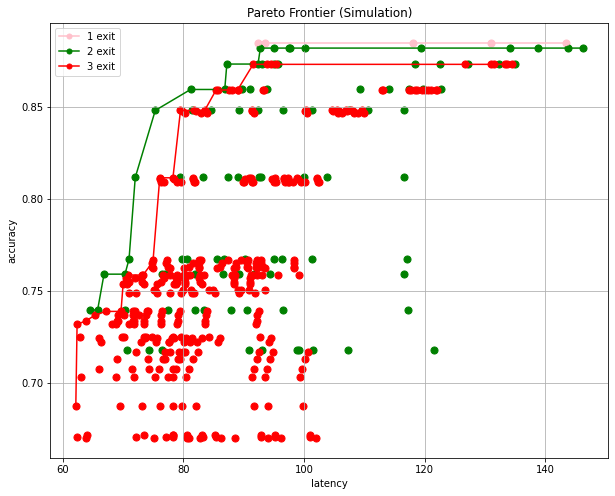

In [90]:
##### analysing just the simulation paretos


def pareto_frontier_finder(latency_list, accuracy_list):
    pareto_frontier = []
    sorted_points = sorted(zip(latency_list, accuracy_list))
    pareto_frontier.append(sorted_points[0])


    for i in range(1, len(sorted_points)):
        if(sorted_points[i][1]<pareto_frontier[-1][1]):
            continue
        pareto_frontier.append(sorted_points[i])
        
    return(list(zip(*sorted_points)), list(zip(*pareto_frontier)))


plt.figure(figsize=(10,8))

(x_points, y_points), (x_pareto_1tier, y_pareto_1tier) = pareto_frontier_finder(t1_simulated_total_latency_list, t1_simulated_accuracy_list)
plt.scatter(x_points, y_points, s=50, color='pink')
plt.plot(x_pareto_1tier, y_pareto_1tier, color='pink', label='1 exit', ms=5, marker='o')

(x_points, y_points), (x_pareto_2tier, y_pareto_2tier) = pareto_frontier_finder(t2_simulated_total_latency_list, t2_simulated_accuracy_list)
plt.scatter(x_points, y_points, s=50, color='g')
plt.plot(x_pareto_2tier, y_pareto_2tier, color='g', label='2 exit', ms=5, marker='o')

(x_points, y_points), (x_pareto_3tier, y_pareto_3tier) = pareto_frontier_finder(t3_simulated_total_latency_list, t3_simulated_accuracy_list)
plt.scatter(x_points, y_points, s=50, color='r')
plt.plot(x_pareto_3tier, y_pareto_3tier, color='r', label='3 exit', ms=5, marker='o')



plt.title("Pareto Frontier (Simulation)")
plt.grid()
plt.legend()
plt.xlabel('latency')
plt.ylabel('accuracy')



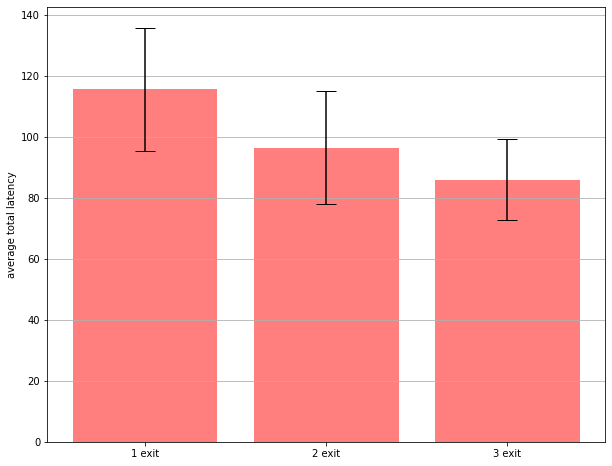

In [78]:
total_mean = [np.mean(t1_simulated_total_latency_list), np.mean(t2_simulated_total_latency_list), np.mean(t3_simulated_total_latency_list)]
total_std = [np.std(t1_simulated_total_latency_list), np.std(t2_simulated_total_latency_list), np.std(t3_simulated_total_latency_list)]
labels = ["1 exit", "2 exit", "3 exit"]
x_pos = np.arange(len(labels))


fig, ax = plt.subplots(figsize=(10,8))
ax.bar(x_pos, total_mean, yerr=total_std, align='center', alpha=0.5, ecolor='black', capsize=10, color='red')
ax.set_ylabel('average total latency')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_xlabel('number of chosen tiers')
ax.yaxis.grid(True)


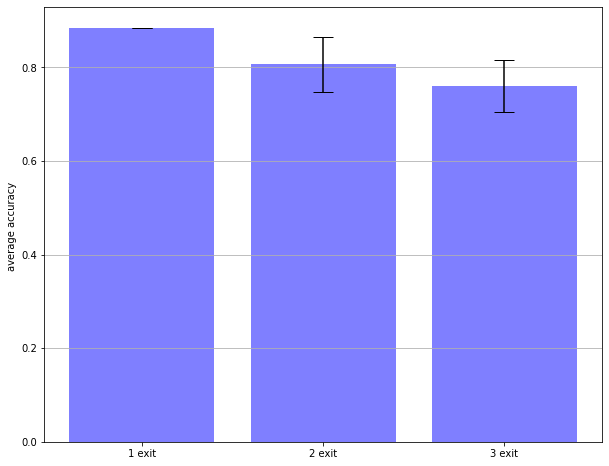

In [79]:
accuracy_mean = [np.mean(t1_simulated_accuracy_list), np.mean(t2_simulated_accuracy_list), np.mean(t3_simulated_accuracy_list)]
accuracy_std = [np.std(t1_simulated_accuracy_list), np.std(t2_simulated_accuracy_list), np.std(t3_simulated_accuracy_list)]
labels = ["1 exit", "2 exit", "3 exit"]
x_pos = np.arange(len(labels))


fig, ax = plt.subplots(figsize=(10,8))
ax.bar(x_pos, accuracy_mean, yerr=accuracy_std, align='center', alpha=0.5, ecolor='black', capsize=10, color='blue')
ax.set_ylabel('average accuracy ')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
# ax.set_xlabel('number of chosen tiers')
ax.yaxis.grid(True)


In [66]:
###### Simulation ve optimization comparision
## now optimization part

In [80]:
###########################################################
### ResNet20 model related information

### all possible branches
branch_number = 10
I = list(range(1, branch_number+1))

input_size = 32*32*3*32
out_size = {1:32*32*16*32, 2:32*32*16*32, 3:32*32*16*32, 4:32*32*16*32, 5:16*16*32*32, 6:16*16*32*32, 7:16*16*32*32, 8:8*8*64*32, 9:8*8*64*32, 10:8*8*64*32}

acc = {1:0.3992, 2:0.5918 , 3:0.6510, 4:0.6742, 5:0.7652, 6:0.8232, 7:0.8432, 8:0.8660, 9: 0.8790, 10:0.8848} 

alpha = dict(zip(I, [0.391538, 0.213815, 0.081094, 0.035173, 0.078104, 0.053637, 0.021061, 0.020858,
 0.014318, 0.090402]))

comp_backbone = dict(zip(I, [1.07619735, 1.57224027, 1.43387813, 1.37183341, 1.66043956, 1.34008288,
 1.33225136, 1.60562826, 1.30284467, 1.29567097]))

comp_exitbranch = dict(zip(I, [0.54828413, 0.56144403, 0.56343376, 0.54711585, 0.54355211, 0.53792531,
 0.53540504, 0.53916863, 0.53609725, 0.53421628]))


### alpha plus is accumulative alpha, to make formulation easier
alpha_plus = {1: alpha.get(1)}
for i in range (1,len(I)):
    alpha_plus[i+1] = round(alpha.get(i+1) + alpha_plus.get(i),4)

print(alpha_plus)


###########################################################
### tier and device related information

### all possible tiers
tier_number = 5
J = list(range(1, tier_number+1))

prop = [10, 20, 20, 10]
bw = [54000, 54000, 1000000, 1000000]
comp_ratio = {1:10, 2:5, 3:2, 4:1, 5:0.5}

### building computation latency matrices
comp_backbone_mat={}
comp_exitbranch_mat={}
for i in I:
    for j in J:
        comp_backbone_mat[i,j] = comp_backbone[i]*comp_ratio[j]
        comp_exitbranch_mat[i,j] = comp_exitbranch[i]*comp_ratio[j]


        
#### other parametes  
option_entire_DNN = True
option_last_tier = False


#### result
class_number = 10
result_size = math.ceil(math.log2(class_number))

{1: 0.391538, 2: 0.6054, 3: 0.6865, 4: 0.7217, 5: 0.7998, 6: 0.8534, 7: 0.8745, 8: 0.8954, 9: 0.9097, 10: 1.0001}


In [81]:
######## Brute Force
#### Changed V2 equal to V1. just simpler for simulation

def objective_function_latency(Y):
    chosen_branches = list(Y.values())
    chosen_tiers = list(Y.keys())
    zip_tier_branch = np.transpose((chosen_tiers, chosen_branches))
    exit_rate_dict = {}
    stay_rate_dict = {}
    lat_p = 0
    lat_t = 0
    lat_c = 0
    
    
    # begining latency (first chosen tier might be after tier 1, but we still need to send data to that tier)
    lat_p += 1 * sum(prop[0:chosen_tiers[0]-1])
    lat_t += 1 * input_size*sum(1/b for b in bw[0:chosen_tiers[0]-1])
    
    
    
    for index, [tier, branch] in enumerate(zip_tier_branch):
        
        prev_branch = 0 if index==0 else zip_tier_branch[index-1][1]
#         print ("----------- tier ", tier, "  branch  ", branch, "  prev branch ", prev_branch)
        
        ######*** ExitRate and StayRate
        # if there's only one chosen branch
        if (tier == chosen_tiers[0] and tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1
            stay_rate_dict[tier] = 0
        
        # if it's first tier, we don't have any previous branch
        elif (tier == chosen_tiers[0]):
            exit_rate_dict[tier] = alpha_plus[branch]
            stay_rate_dict[tier] = 1- alpha_plus[branch]
            
        
        # if it's last tier, everything exits
        elif (tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1 - alpha_plus[prev_branch]
            stay_rate_dict[tier] = 0
            
        # other normal cases
        else:
            exit_rate_dict[tier] = alpha_plus[branch] - alpha_plus[prev_branch]
            stay_rate_dict[tier] = 1- alpha_plus[branch]
            

            
        ######*** computation latency
        lat_c += (exit_rate_dict[tier]+stay_rate_dict[tier])*sum(comp_backbone_mat[a, tier] for a in list(range(prev_branch+1, branch+1)))
        lat_c += (exit_rate_dict[tier])*comp_exitbranch_mat[branch, tier]
    


        ######*** propagation latency and transmission latency, only if it's not last tier
        if (tier != chosen_tiers[-1]):
            next_tier = zip_tier_branch[index+1][0]
            lat_p += stay_rate_dict[tier] * sum(prop[tier-1: next_tier-1])
            lat_t += stay_rate_dict[tier] * out_size[branch]*sum(1/b for b in bw[tier-1: next_tier-1])
            
    
    ##### sending back results latency (propagation and transmission, no computation is done)
    for [tier, branch] in zip(chosen_tiers, chosen_branches):
        lat_p += exit_rate_dict[tier]*sum(prop[0:tier-1])
        lat_t += exit_rate_dict[tier]*result_size*sum(1/b for b in bw[0: tier-1])

    
    
    return exit_rate_dict, stay_rate_dict, lat_p, lat_t, lat_c





def objective_function_accuracy(Y):
    average_acc = 0
    
    chosen_branches = list(Y.values())
    chosen_tiers = list(Y.keys())
    exit_rate_dict = {}
    
    #### Exit rate 
    prev_branch = 0
    for [tier, branch] in zip(chosen_tiers, chosen_branches):
        
        # if there's only one chosen branch
        if (tier == chosen_tiers[0] and tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1
        
        # if it's first tier, we don't have any previous branch
        elif (tier == chosen_tiers[0]):
            exit_rate_dict[tier] = alpha_plus[branch]
            
        
        # if it's last tier, everything exits
        elif (tier == chosen_tiers[-1]):
            exit_rate_dict[tier] = 1 - alpha_plus[prev_branch]
            
        # other normal cases
        else:
            exit_rate_dict[tier] = alpha_plus[branch] - alpha_plus[prev_branch]
            
        average_acc += exit_rate_dict[tier]*acc[branch]
        
        prev_branch = branch
    return (average_acc)



In [82]:
### number of chosen branches it can be 1 to tier_number
chosen_number = 1


### two options, using entire DNN model or not, always finishing at last tier or not
### about option two: for the first tier we always pay for it even if it's not chosen, the begining is alway tier 1
option_entire_DNN = True
option_last_tier = False

def func_list_to_dict(li):
    di = {}
    for i in range(len(li)):
        if(li[i]!=0):
            di[i+1]=li[i]
    return di

t1_opt_placement_with0_list = []
t1_opt_exit_rate_list = []
t1_opt_stay_rate_list = []
t1_opt_prop_latency_list = []
t1_opt_trans_latency_list = []
t1_opt_comp_latency_list = []
t1_opt_total_latency_list = []
t1_opt_accuracy_list = []
t1_opt_placement_list = []

for item in combinations(I, chosen_number):
    
    #### constraint about using the entire DNN model
    if (len(I) not in item and option_entire_DNN == True):
        continue
    
    print("--------------------  ", item)
    item = list(item) + [0 for i in range(tier_number - chosen_number)]
    

    
    for placement in permutations(item, tier_number):
        if (sorted([i for i in placement if i!=0]) == [i for i in placement if i!=0] and list(placement) not in t1_opt_placement_with0_list):

            t1_opt_placement_with0_list.append(list(placement))
            placement_dict = func_list_to_dict(list(placement))
            t1_opt_placement_list.append(placement_dict)
            print("***** ", placement_dict)
            
            res = objective_function_latency(placement_dict)
            accc = objective_function_accuracy(placement_dict)
            
            print("exit rate ", res[0])
            print("stay rate ", res[1])
            print("prop lat ", res[2], "  trans lat ", res[3], "  comp lat ", res[4])
            print("total lat ", res[2]+res[3]+res[4])
            print("accuracy ", accc)
            t1_opt_exit_rate_list.append(res[0])
            t1_opt_stay_rate_list.append(res[1])
            t1_opt_prop_latency_list.append(res[2])
            t1_opt_trans_latency_list.append(res[3])
            t1_opt_comp_latency_list.append(res[4])
            t1_opt_total_latency_list.append(res[2]+res[3]+res[4])
            t1_opt_accuracy_list.append(accc)
            

print ("%%%%%%%%%%%%%%% optimization result %%%%%%%%%%%%%%%")
print("min latency: value->   ", min(t1_opt_total_latency_list), "  placement->  ", t1_opt_placement_list[t1_opt_total_latency_list.index(min(t1_opt_total_latency_list))])
print("max accuracy: value->   ", max(t1_opt_accuracy_list), "   placement->   ", t1_opt_placement_list[t1_opt_accuracy_list.index(max(t1_opt_accuracy_list))])
 

--------------------   (10,)
*****  {1: 10}
exit rate  {1: 1}
stay rate  {1: 0}
prop lat  0   trans lat  0   comp lat  145.25283140000002
total lat  145.25283140000002
accuracy  0.8848
*****  {2: 10}
exit rate  {2: 1}
stay rate  {2: 0}
prop lat  20   trans lat  1.8205185185185186   comp lat  72.62641570000001
total lat  94.44693421851852
accuracy  0.8848
*****  {3: 10}
exit rate  {3: 1}
stay rate  {3: 0}
prop lat  60   trans lat  3.6410370370370373   comp lat  29.050566280000005
total lat  92.69160331703705
accuracy  0.8848
*****  {4: 10}
exit rate  {4: 1}
stay rate  {4: 0}
prop lat  100   trans lat  3.739345037037037   comp lat  14.525283140000003
total lat  118.26462817703704
accuracy  0.8848
*****  {5: 10}
exit rate  {5: 1}
stay rate  {5: 0}
prop lat  120   trans lat  3.8376530370370365   comp lat  7.262641570000001
total lat  131.10029460703706
accuracy  0.8848
%%%%%%%%%%%%%%% optimization result %%%%%%%%%%%%%%%
min latency: value->    92.69160331703705   placement->   {3: 10}
max 

In [83]:
### number of chosen branches it can be 1 to tier_number
chosen_number = 2


### two options, using entire DNN model or not, always finishing at last tier or not
### about option two: for the first tier we always pay for it even if it's not chosen, the begining is alway tier 1
option_entire_DNN = True
option_last_tier = False

def func_list_to_dict(li):
    di = {}
    for i in range(len(li)):
        if(li[i]!=0):
            di[i+1]=li[i]
    return di

t2_opt_placement_with0_list = []
t2_opt_exit_rate_list = []
t2_opt_stay_rate_list = []
t2_opt_prop_latency_list = []
t2_opt_trans_latency_list = []
t2_opt_comp_latency_list = []
t2_opt_total_latency_list = []
t2_opt_accuracy_list = []
t2_opt_placement_list = []

for item in combinations(I, chosen_number):
    
    #### constraint about using the entire DNN model
    if (len(I) not in item and option_entire_DNN == True):
        continue
    
    print("--------------------  ", item)
    item = list(item) + [0 for i in range(tier_number - chosen_number)]
    

    
    for placement in permutations(item, tier_number):
        if (sorted([i for i in placement if i!=0]) == [i for i in placement if i!=0] and list(placement) not in t2_opt_placement_with0_list):

            t2_opt_placement_with0_list.append(list(placement))
            placement_dict = func_list_to_dict(list(placement))
            t2_opt_placement_list.append(placement_dict)
            print("***** ", placement_dict)
            
            res = objective_function_latency(placement_dict)
            accc = objective_function_accuracy(placement_dict)
            
            print("exit rate ", res[0])
            print("stay rate ", res[1])
            print("prop lat ", res[2], "  trans lat ", res[3], "  comp lat ", res[4])
            print("total lat ", res[2]+res[3]+res[4])
            print("accuracy ", accc)
            t2_opt_exit_rate_list.append(res[0])
            t2_opt_stay_rate_list.append(res[1])
            t2_opt_prop_latency_list.append(res[2])
            t2_opt_trans_latency_list.append(res[3])
            t2_opt_comp_latency_list.append(res[4])
            t2_opt_total_latency_list.append(res[2]+res[3]+res[4])
            t2_opt_accuracy_list.append(accc)
            

print ("%%%%%%%%%%%%%%% optimization result %%%%%%%%%%%%%%%")
print("min latency: value->   ", min(t2_opt_total_latency_list), "  placement->  ", t2_opt_placement_list[t2_opt_total_latency_list.index(min(t2_opt_total_latency_list))])
print("max accuracy: value->   ", max(t2_opt_accuracy_list), "   placement->   ", t2_opt_placement_list[t2_opt_accuracy_list.index(max(t2_opt_accuracy_list))])
 

--------------------   (1, 10)
*****  {1: 1, 2: 10}
exit rate  {1: 0.391538, 2: 0.6084620000000001}
stay rate  {1: 0.6084620000000001, 2: 0}
prop lat  12.169240000000002   trans lat  5.90762516488889   comp lat  53.8250024066943
total lat  71.9018675715832
accuracy  0.6946691472000001
*****  {1: 1, 3: 10}
exit rate  {1: 0.391538, 3: 0.6084620000000001}
stay rate  {1: 0.6084620000000001, 3: 0}
prop lat  36.507720000000006   trans lat  11.81525032977778   comp lat  29.27522949282936
total lat  77.59819982260714
accuracy  0.6946691472000001
*****  {1: 1, 4: 10}
exit rate  {1: 0.391538, 4: 0.6084620000000001}
stay rate  {1: 0.6084620000000001, 4: 0}
prop lat  60.8462   trans lat  12.134262088681778   comp lat  21.09197185487438
total lat  94.07243394355615
accuracy  0.6946691472000001
*****  {1: 1, 5: 10}
exit rate  {1: 0.391538, 5: 0.6084620000000001}
stay rate  {1: 0.6084620000000001, 5: 0}
prop lat  73.01544000000001   trans lat  12.453273847585777   comp lat  17.00034303589689
total la

In [84]:
### number of chosen branches it can be 1 to tier_number
chosen_number = 3


### two options, using entire DNN model or not, always finishing at last tier or not
### about option two: for the first tier we always pay for it even if it's not chosen, the begining is alway tier 1
option_entire_DNN = True
option_last_tier = False

def func_list_to_dict(li):
    di = {}
    for i in range(len(li)):
        if(li[i]!=0):
            di[i+1]=li[i]
    return di

t3_opt_placement_with0_list = []
t3_opt_exit_rate_list = []
t3_opt_stay_rate_list = []
t3_opt_prop_latency_list = []
t3_opt_trans_latency_list = []
t3_opt_comp_latency_list = []
t3_opt_total_latency_list = []
t3_opt_accuracy_list = []
t3_opt_placement_list = []

for item in combinations(I, chosen_number):
    
    #### constraint about using the entire DNN model
    if (len(I) not in item and option_entire_DNN == True):
        continue
    
    print("--------------------  ", item)
    item = list(item) + [0 for i in range(tier_number - chosen_number)]
    

    
    for placement in permutations(item, tier_number):
        if (sorted([i for i in placement if i!=0]) == [i for i in placement if i!=0] and list(placement) not in t3_opt_placement_with0_list):

            t3_opt_placement_with0_list.append(list(placement))
            placement_dict = func_list_to_dict(list(placement))
            t3_opt_placement_list.append(placement_dict)
            print("***** ", placement_dict)
            
            res = objective_function_latency(placement_dict)
            accc = objective_function_accuracy(placement_dict)
            
            print("exit rate ", res[0])
            print("stay rate ", res[1])
            print("prop lat ", res[2], "  trans lat ", res[3], "  comp lat ", res[4])
            print("total lat ", res[2]+res[3]+res[4])
            print("accuracy ", accc)
            t3_opt_exit_rate_list.append(res[0])
            t3_opt_stay_rate_list.append(res[1])
            t3_opt_prop_latency_list.append(res[2])
            t3_opt_trans_latency_list.append(res[3])
            t3_opt_comp_latency_list.append(res[4])
            t3_opt_total_latency_list.append(res[2]+res[3]+res[4])
            t3_opt_accuracy_list.append(accc)
            

print ("%%%%%%%%%%%%%%% optimization result %%%%%%%%%%%%%%%")
print("min latency: value->   ", min(t3_opt_total_latency_list), "  placement->  ", t3_opt_placement_list[t3_opt_total_latency_list.index(min(t3_opt_total_latency_list))])
print("max accuracy: value->   ", max(t3_opt_accuracy_list), "   placement->   ", t3_opt_placement_list[t3_opt_accuracy_list.index(max(t3_opt_accuracy_list))])
 

--------------------   (1, 2, 10)
*****  {1: 1, 2: 2, 3: 10}
exit rate  {1: 0.391538, 2: 0.21386200000000005, 3: 0.39459999999999995}
stay rate  {1: 0.6084620000000001, 2: 0.39459999999999995, 3: 0}
prop lat  27.95324   trans lat  9.738840409333333   comp lat  27.665520712846398
total lat  65.35760112217973
accuracy  0.6320075812
*****  {1: 1, 2: 2, 4: 10}
exit rate  {1: 0.391538, 2: 0.21386200000000005, 4: 0.39459999999999995}
stay rate  {1: 0.6084620000000001, 2: 0.39459999999999995, 4: 0}
prop lat  43.73724   trans lat  9.945726032533335   comp lat  22.978917470654398
total lat  76.66188350318774
accuracy  0.6320075812
*****  {1: 1, 2: 2, 5: 10}
exit rate  {1: 0.391538, 2: 0.21386200000000005, 5: 0.39459999999999995}
stay rate  {1: 0.6084620000000001, 2: 0.39459999999999995, 5: 0}
prop lat  51.629239999999996   trans lat  10.152611655733335   comp lat  20.635615849558402
total lat  82.41746750529174
accuracy  0.6320075812
*****  {1: 1, 3: 2, 4: 10}
exit rate  {1: 0.391538, 3: 0.2138

total lat  77.18353770820185
accuracy  0.7164755
*****  {3: 3, 4: 7, 5: 10}
exit rate  {3: 0.6865, 4: 0.18800000000000006, 5: 0.12549999999999994}
stay rate  {3: 0.3135, 4: 0.12549999999999994, 5: 0}
prop lat  75.05   trans lat  3.8383021530370374   comp lat  11.12460866163
total lat  90.01291081466704
accuracy  0.7164755
--------------------   (3, 8, 10)
*****  {1: 3, 2: 8, 3: 10}
exit rate  {1: 0.6865, 2: 0.20889999999999997, 3: 0.10460000000000003}
stay rate  {1: 0.3135, 2: 0.10460000000000003, 3: 0}
prop lat  10.454   trans lat  3.2977054   comp lat  57.36845351332399
total lat  71.12015891332399
accuracy  0.7203689799999999
*****  {1: 3, 2: 8, 4: 10}
exit rate  {1: 0.6865, 2: 0.20889999999999997, 4: 0.10460000000000003}
stay rate  {1: 0.3135, 2: 0.10460000000000003, 4: 0}
prop lat  14.638000000000002   trans lat  3.3114159495999997   comp lat  57.040769754492
total lat  74.990185704092
accuracy  0.7203689799999999
*****  {1: 3, 2: 8, 5: 10}
exit rate  {1: 0.6865, 2: 0.208899999999

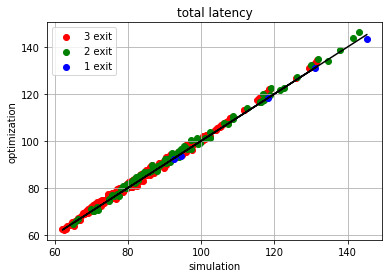

In [85]:
plt.plot(t3_opt_total_latency_list, t3_opt_total_latency_list, c="black")
plt.plot(t1_opt_total_latency_list, t1_opt_total_latency_list, c="black")
plt.scatter(t3_opt_total_latency_list,t3_simulated_total_latency_list, c="red", label='3 exit')
plt.scatter(t2_opt_total_latency_list,t2_simulated_total_latency_list, c="green", label='2 exit')
plt.scatter(t1_opt_total_latency_list,t1_simulated_total_latency_list, c="blue", label='1 exit')
plt.title("total latency")
plt.grid()
plt.xlabel("simulation")
plt.ylabel("optimization")
plt.legend()
plt.show()


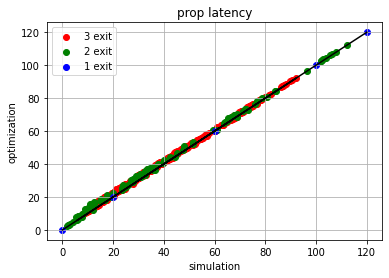

In [86]:
plt.plot(t3_opt_prop_latency_list, t3_opt_prop_latency_list, c="black")
plt.plot(t1_opt_prop_latency_list, t1_opt_prop_latency_list, c="black")
plt.scatter(t3_opt_prop_latency_list,t3_simulated_prop_latency_list, c="red", label='3 exit')
plt.scatter(t2_opt_prop_latency_list,t2_simulated_prop_latency_list, c="green", label='2 exit')
plt.scatter(t1_opt_prop_latency_list,t1_simulated_prop_latency_list, c="blue", label='1 exit')
plt.title("prop latency")
plt.grid()
plt.xlabel("simulation")
plt.ylabel("optimization")
plt.legend()
plt.show()


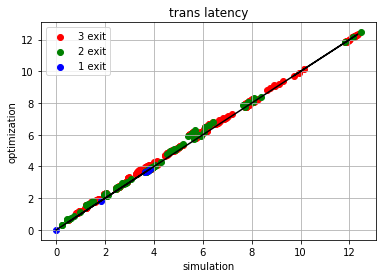

In [87]:
plt.plot(t3_opt_trans_latency_list, t3_opt_trans_latency_list, c="black")
plt.plot(t1_opt_trans_latency_list, t1_opt_trans_latency_list, c="black")
plt.scatter(t3_opt_trans_latency_list,t3_simulated_trans_latency_list, c="red", label='3 exit')
plt.scatter(t2_opt_trans_latency_list,t2_simulated_trans_latency_list, c="green", label='2 exit')
plt.scatter(t1_opt_trans_latency_list,t1_simulated_trans_latency_list, c="blue", label='1 exit')
plt.title("trans latency")
plt.grid()
plt.xlabel("simulation")
plt.ylabel("optimization")
plt.legend()
plt.show()


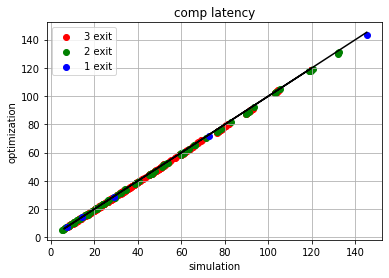

In [88]:
plt.plot(t3_opt_comp_latency_list, t3_opt_comp_latency_list, c="black")
plt.plot(t1_opt_comp_latency_list, t1_opt_comp_latency_list, c="black")
plt.scatter(t3_opt_comp_latency_list,t3_simulated_comp_latency_list, c="red", label='3 exit')
plt.scatter(t2_opt_comp_latency_list,t2_simulated_comp_latency_list, c="green", label='2 exit')
plt.scatter(t1_opt_comp_latency_list,t1_simulated_comp_latency_list, c="blue", label='1 exit')
plt.title("comp latency")
plt.grid()
plt.xlabel("simulation")
plt.ylabel("optimization")
plt.legend()
plt.show()


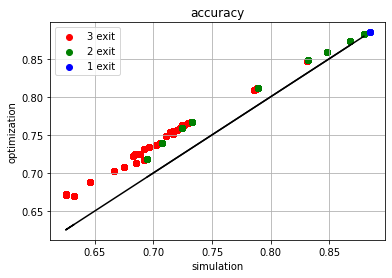

In [89]:
plt.plot(t3_opt_accuracy_list, t3_opt_accuracy_list, c="black")
plt.plot(t2_opt_accuracy_list, t2_opt_accuracy_list, c="black")
plt.scatter(t3_opt_accuracy_list,t3_simulated_accuracy_list, c="red", label='3 exit')
plt.scatter(t2_opt_accuracy_list,t2_simulated_accuracy_list, c="green", label='2 exit')
plt.scatter(t1_opt_accuracy_list,t1_simulated_accuracy_list, c="blue", label='1 exit')
plt.title("accuracy")
plt.grid()
plt.xlabel("simulation")
plt.ylabel("optimization")
plt.legend()
plt.show()
